In [1]:
import dill
import gzip

In [2]:
model = dill.load(gzip.open("./results/BERT4rec.ml-1m/ml1m_generative_2023_04_18T16_32_02/checkpoints/gpt2rec-id.dill.gz"))

2023-04-27 07:55:13.380877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 07:55:14.149647: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-27 07:55:14.149690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-27 07:55:14.149694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-04-19 15:21:36     19936380
metadata.json                                  2023-04-19 15:21:36           64
config.json                                    2023-04-19 15:21:36          510


2023-04-27 07:55:18.330286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
/home/alekspet/aprec/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...gpt
......layers
.........tfgpt2_main_layer
............drop
...............vars
............h
...............tf_block
..................attn
.....................attn_dropout
........................vars
.....................c_attn
........................vars
...........................0
...........................1
.....................c_proj
........................vars
...........................0
...........................1
.....................resid_dropout
........................vars
.....................vars
..................ln_1
.....................vars
........................0
........................1
..................ln_2
.....................vars
........................0
........................1
..................mlp
.....................c_fc
........................vars
...........................0
...........................1
.....................c_proj
........................vars
............

In [3]:
gptrec = model.recommender

In [4]:
from aprec.datasets.datasets_register import DatasetsRegister

In [5]:
register = DatasetsRegister()
ml_dataset = register['BERT4rec.ml-1m']()

In [6]:
from collections import defaultdict
by_user = defaultdict(list)
for action in ml_dataset:
    uid = gptrec.users.get_id(action.user_id)
    iid = gptrec.items.get_id(action.item_id)
    by_user[uid].append(iid)

In [7]:
import numpy as np

gpt = gptrec.model.gpt
import tensorflow as tf
from tqdm import tqdm

gt_pos = []
for user in tqdm(by_user):
    seq = by_user[user][:-1]
    seen = set(seq)
    test_act = by_user[user][-1]
    gpt_input = tf.convert_to_tensor([seq])
    output = gpt(gpt_input)
    logits = output.logits[0,-1,:gptrec.items.size()]
    res = np.argsort(logits)[::-1]
    res = list(filter(lambda x: int(x) not in seen, res))
    found = False
    for j in range(len(res)):
        if res[j] == test_act:
            gt_pos.append(j+1)
            found = True
            break
    assert(found)
        
            
        

100%|███████████████████████████████████████| 6040/6040 [02:12<00:00, 45.63it/s]


In [8]:
gt_pos = np.array(gt_pos)

In [9]:
def recall_k(pos, k):
    return np.sum(pos <= k) / len(pos)

def ndcg_k(pos, k):
    ok = np.float32(pos <= k)
    res = 1/np.log2(pos + 1)
    return np.sum(res*ok) / len(pos)


recall_k(gt_pos, 100)

0.580794701986755

In [10]:
gen_rec_pos = []
max_it = 10

for user in tqdm(by_user):
    seq = by_user[user][:-1]
    seen = set(seq)
    test_act = by_user[user][-1]
    it = 1 
    while True:
        gpt_input = tf.convert_to_tensor([seq])
        output = gpt(gpt_input)
        logits = output.logits[0,-1,:gptrec.items.size()]
        res = np.argsort(logits)[::-1]
        res = list(filter(lambda x: int(x) not in seen, res))
        if res[0] == test_act:
            gen_rec_pos.append(it)
            break
        else:
            seq.append(res[0])
            seen.add(res[0])
            #print(res[0], test_act)
            it += 1
            if it > max_it:
                gen_rec_pos.append(it)
                break

100%|███████████████████████████████████████| 6040/6040 [19:28<00:00,  5.17it/s]


In [11]:
gen_rec_pos = np.array(gen_rec_pos)

In [12]:
recall_k(gen_rec_pos, 10)

0.15711920529801324

In [13]:
ndcg_k(gen_rec_pos, 10)

0.10503794568013251

In [14]:
docs = []
import pandas as pd

for i in range(1,11):
    docs.append([i, ndcg_k(gen_rec_pos, i), ndcg_k(gt_pos, i), recall_k(gen_rec_pos, i), recall_k(gt_pos, i)])
columns = ["cutoff", "generative_ndcg@cutoff", "topk_ndcg@cutoff", "generative_recall@cutoff", "topk_recall@cutoff"]
res = pd.DataFrame(docs, columns=columns).set_index('cutoff')
res

,generative_ndcg@cutoff,topk_ndcg@cutoff,generative_recall@cutoff,topk_recall@cutoff
cutoff,,,,
1,0.059272,0.059272,0.059272,0.059272
2,0.077761,0.084446,0.088576,0.099172
3,0.085956,0.098933,0.104967,0.128146
4,0.091732,0.108274,0.118377,0.149834
5,0.095895,0.116728,0.129139,0.171689
6,0.099197,0.122920,0.138411,0.189073
7,0.101295,0.128494,0.144702,0.205795
8,0.102496,0.133613,0.148510,0.222020
9,0.103841,0.138198,0.152980,0.237252


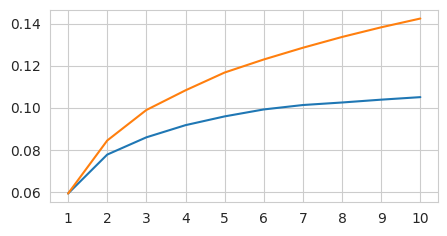

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import tikzplotlib



sns.set_style('whitegrid')
plt.figure(figsize=(5,2.5))
plt.plot(res.index, res['generative_ndcg@cutoff'])
plt.plot(res.index, res['topk_ndcg@cutoff'])
plt.xticks([1,2,3,4,5,6,7,8,9,10])


tikzplotlib.save("generative_ndcg.tex")

In [18]:
print(res.to_csv())

cutoff,generative_ndcg@cutoff,topk_ndcg@cutoff,generative_recall@cutoff,topk_recall@cutoff
1,0.05927152317880795,0.05927152317880795,0.05927152317880795,0.05927152317880795
2,0.07776068979836888,0.084446038180583,0.08857615894039735,0.09917218543046358
3,0.08595605403677949,0.09893279314747042,0.10496688741721855,0.12814569536423842
4,0.09173168337518094,0.10827362578118142,0.1183774834437086,0.1498344370860927
5,0.09589483444641357,0.11672802487968464,0.1291390728476821,0.1716887417218543
6,0.09919741763814359,0.12292036836417841,0.13841059602649006,0.1890728476821192
7,0.1012945478809692,0.12849431979905698,0.1447019867549669,0.20579470198675498
8,0.10249582141839829,0.13361278965418968,0.14850993377483443,0.22201986754966888
9,0.10384148530630022,0.13819801475370727,0.15298013245033112,0.23725165562913908
10,0.10503794568013251,0.14236169685464373,0.15711920529801324,0.25165562913907286

